# Pre Processing Amazon Sentiment Analysis Dataset

In [ ]:
!pip install tiktoken pyspark matplotlib

In [1]:
import os
import requests
import tarfile

DOWNLOAD_URL = "https://github.com/Digital-Defiance/llm-voice-chat/releases/download/dataset-release-amazon-reviews/original_amazon_review_full_csv.tar.gz"

# download file
r = requests.get(DOWNLOAD_URL, stream=True)
with open("original_amazon_review_full_csv.tar.gz", "wb") as f:
    for chunk in r.iter_content(chunk_size=8192):
        f.write(chunk)


# extract file
with tarfile.open("original_amazon_review_full_csv.tar.gz", "r:gz") as tar:
    tar.extractall()


for dirname, _, filenames in os.walk('./amazon_review_full_csv'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./amazon_review_full_csv/readme.txt
./amazon_review_full_csv/train.csv
./amazon_review_full_csv/test.csv


In [2]:
!cat ./amazon_review_full_csv/readme.txt

Amazon Review Full Score Dataset

Version 3, Updated 09/09/2015

ORIGIN

The Amazon reviews dataset consists of reviews from amazon. The data span a period of 18 years, including ~35 million reviews up to March 2013. Reviews include product and user information, ratings, and a plaintext review. For more information, please refer to the following paper: J. McAuley and J. Leskovec. Hidden factors and hidden topics: understanding rating dimensions with review text. RecSys, 2013.

The Amazon reviews full score dataset is constructed by Xiang Zhang (xiang.zhang@nyu.edu) from the above dataset. It is used as a text classification benchmark in the following paper: Xiang Zhang, Junbo Zhao, Yann LeCun. Character-level Convolutional Networks for Text Classification. Advances in Neural Information Processing Systems 28 (NIPS 2015).


DESCRIPTION

The Amazon reviews full score dataset is constructed by randomly taking 600,000 training samples and 130,000 testing samples for each review score from 

#### Init notebook

In [3]:

from pipeline_utils import *

In [4]:
input(Paths.TRAIN_DATA) >> read_csv >> show(10, truncate=False)

24/02/19 14:26:01 WARN Utils: Your hostname, codespaces-df4b36 resolves to a loopback address: 127.0.0.1; using 172.16.5.4 instead (on interface eth0)
24/02/19 14:26:01 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/02/19 14:26:03 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


+------+-------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|rating|title                                |text                                                                                                                                                                                  

24/02/19 14:26:21 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


In [12]:
input(Paths.TEST_DATA) >> read_csv >> show(10, truncate=False)

+------+---------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|rating|title                            |text                                                                                                                                                                                                                                                                                                            

In [98]:

print("Train data")
(
    input(Paths.TRAIN_DATA) 
    >> read_csv 
    >> select(
        expr("count(*) - count(text)"),
        expr("count(*) - count(title)"),
        expr("count(*) - count(rating)")
    )
    >> show()
)()


print("Test data")
(
    input(Paths.TEST_DATA) 
    >> read_csv
    >> select(
        expr("count(*) - count(text)"),
        expr("count(*) - count(title)"),
        expr("count(*) - count(rating)")
    )
    >> show()
)()

Train data


+------------------------+-------------------------+--------------------------+
|(count(1) - count(text))|(count(1) - count(title))|(count(1) - count(rating))|
+------------------------+-------------------------+--------------------------+
|                       0|                       46|                         0|
+------------------------+-------------------------+--------------------------+

Test data
+------------------------+-------------------------+--------------------------+
|(count(1) - count(text))|(count(1) - count(title))|(count(1) - count(rating))|
+------------------------+-------------------------+--------------------------+
|                       0|                        2|                         0|
+------------------------+-------------------------+--------------------------+



DataFrame[(count(1) - count(text)): bigint, (count(1) - count(title)): bigint, (count(1) - count(rating)): bigint]

There's a bunch of empty titles in there, we'll just not add them to the body. The preprocess_text function will make the text uncased and prepend the title to the review.

In [101]:
input(Paths.TEST_DATA) >> read_csv >> preprocess_text >> show(10, truncate=False)

+------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|rating|text                                                                                                                                                                                                                                                                                                                                                  

In [102]:
input(Paths.TRAIN_DATA) >> read_csv >> preprocess_text >> show(10, truncate=False)

+------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|rating|text                                                                                                                                                                                                                                                

In [103]:

print("Train data")

(
    input(Paths.TRAIN_DATA) 
    >> read_csv
    >> preprocess_text
    >> select(
        expr("count(*) - count(text)"),
        expr("count(*) - count(rating)")
    )
    >> show()
)()


print("Test data")
(
    input(Paths.TEST_DATA) 
    >> read_csv
    >> preprocess_text
    >> select(
        expr("count(*) - count(text)"),
        expr("count(*) - count(rating)")
    )
    >> show()
)()

Train data


+------------------------+--------------------------+
|(count(1) - count(text))|(count(1) - count(rating))|
+------------------------+--------------------------+
|                       0|                         0|
+------------------------+--------------------------+

Test data


+------------------------+--------------------------+
|(count(1) - count(text))|(count(1) - count(rating))|
+------------------------+--------------------------+
|                       0|                         0|
+------------------------+--------------------------+



DataFrame[(count(1) - count(text)): bigint, (count(1) - count(rating)): bigint]

In [105]:
input(Paths.TEST_DATA) >> read_csv >> preprocess_text >> encode_dataframe_text >> show(10, truncate=False)

+------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|rating|text                                                                                                                                                                                                                

In [106]:
input(Paths.TRAIN_DATA) >> read_csv >> preprocess_text >> encode_dataframe_text >> show(10, truncate=False)

+------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|rating|text         

#### Determining context window

In [130]:
sizes_test_data = (
    input(Paths.TEST_DATA) 
    >> read_csv 
    # >> limit(5) 
    >> preprocess_text 
    >> encode_dataframe_text
    >> select(expr("size(text)"))
    >> collect()
    >> to_numpy
    >> pipeline_function(lambda x: x.flatten())
)()

In [137]:
sizes_train_data = (
    input(Paths.TRAIN_DATA) 
    >> read_csv 
    # >> limit(5) 
    >> preprocess_text 
    >> encode_dataframe_text
    >> select(expr("size(text)"))
    >> collect()
    >> to_numpy
    >> pipeline_function(lambda x: x.flatten())
)()

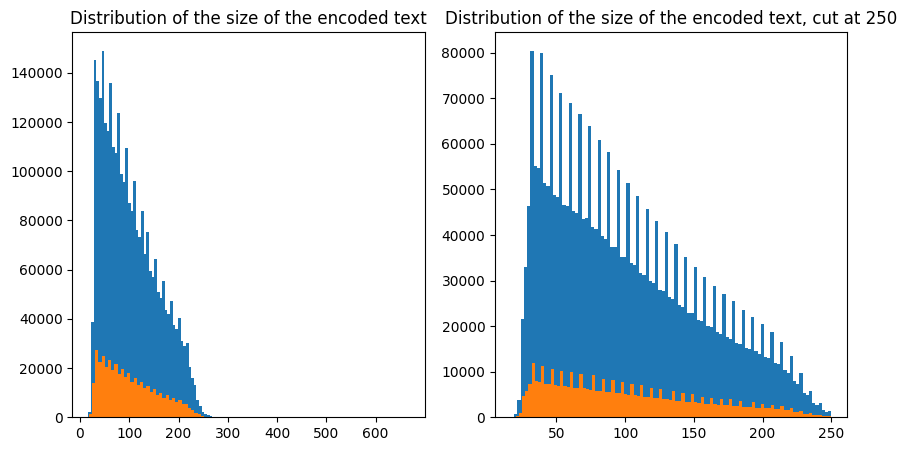

<Figure size 640x480 with 0 Axes>

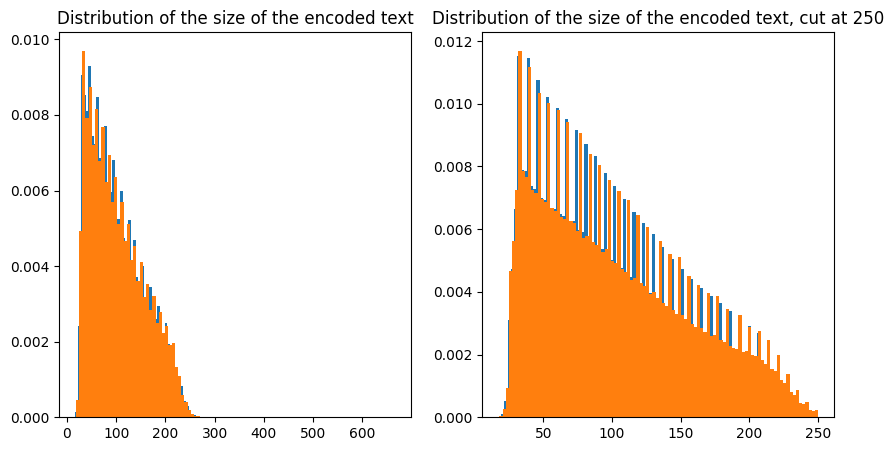

In [151]:
import matplotlib.pyplot as plt


def plot(with_density: bool):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.hist(sizes_train_data, bins=100, density=with_density)
    plt.hist(sizes_test_data, bins=100,     density=with_density)
    plt.title("Distribution of the size of the encoded text")


    plt.subplot(1, 2, 2)
    plt.hist(sizes_train_data[sizes_train_data <= 250], bins=100, density=with_density )
    plt.hist(sizes_test_data[sizes_test_data <= 250], bins=100,density=with_density )
    plt.title("Distribution of the size of the encoded text, cut at 250")


plot(with_density=False)
plt.figure()


# With normalization to check that the distributions match
plot(with_density=True)


In [161]:
(
    input(Paths.TEST_DATA) 
    >> read_csv 
    >> limit(100) 
    >> preprocess_text 
    >> encode_dataframe_text
    >> select("*", expr("size(text) as size"))
    >> filter(col("size") <= 250)
    >> select("rating", expr(f"concat(text, array_repeat({PAD_TOKEN}, 250 - size(text))) as text"))
    >> select("text")
    >> collect()
    >> to_numpy
    >> pipeline_function(lambda arr: arr[:, 0, :])
)()

array([[45535, 32866,   258, ..., 50282, 50282, 50282],
       [41199, 32327,    13, ..., 50282, 50282, 50282],
       [ 5225,    11,   475, ..., 50282, 50282, 50282],
       ...,
       [ 4598,   356,  3443, ..., 50282, 50282, 50282],
       [   86,  8623,   913, ..., 50282, 50282, 50282],
       [  548,  6249,   499, ..., 50282, 50282, 50282]])

In [166]:




test_rating, test_text = (
    input(Paths.TEST_DATA) 
    >> read_csv 
    # >> limit(100) 
    >> preprocess_text 
    >> encode_dataframe_text
    >> select("*", expr("size(text) as size"))
    >> filter(col("size") <= 250)
    >> select("rating", expr(f"concat(text, array_repeat({PAD_TOKEN}, 250 - size(text))) as text"))
    >> collect()
    >> columns_to_numpy
)()

np.savez_compressed("test.npz", rating=test_rating, text=test_text)

In [167]:
!aws s3 cp /workspaces/llm-voice-chat/data/test.npz s3://digitaldefiancemlartifacts/

upload: ./test.npz to s3://digitaldefiancemlartifacts/test.npz    


In [3]:

import uuid
from pipeline_utils import *


tmp_path = uuid.uuid4().hex

get_or_create_spark_session()

(
    input(Paths.TRAIN_DATA) 
    >> csv(header = False, inferSchema = False, escape = '"', multiLine = True, mode = "FAILFAST", schema=CSV_SCHEMA) 
    # >> limit(100)
    >> preprocess_text
    >> encode_dataframe_text
    >> select("*", expr("size(text) as size"))
    >> filter(col("size") <= 250)
    >> select(
        "rating",
        expr(f"concat(text, array_repeat({PAD_TOKEN}, 250 - size(text))) as text")
    )
    >> repartition(10)
    >> write_parquet(tmp_path)
    >> show()
)()

print(tmp_path)


+------+--------------------+
|rating|                text|
+------+--------------------+
|     2|[2375, 504, 276, ...|
|     1|[9099, 470, 7030,...|
|     4|[2502, 477, 922, ...|
|     1|[24588, 5036, 270...|
|     4|[11274, 3572, 138...|
|     3|[270, 373, 19551,...|
|     5|[18223, 1621, 13,...|
|     3|[3826, 832, 1221,...|
|     3|[548, 922, 475, 1...|
|     3|[22043, 1720, 475...|
|     5|[24498, 1466, 13,...|
|     1|[26316, 329, 2147...|
|     1|[3919, 736, 510, ...|
|     5|[40635, 915, 358,...|
|     5|[5420, 411, 722, ...|
|     5|[64, 14068, 13, 1...|
|     2|[72, 760, 345, 76...|
|     5|[11793, 14619, 43...|
|     5|[2501, 12, 19315,...|
|     1|[23350, 5287, 13,...|
+------+--------------------+
only showing top 20 rows

42c94a245335442cb1341f32a0c45668


Current path: 42c94a245335442cb1341f32a0c45668

In [2]:

import os

current_tmp_path = "42c94a245335442cb1341f32a0c45668"

def list_parquet_files():
    for dirname, _, filenames in os.walk(current_tmp_path):
        for filename in filenames:
            if filename.endswith(".parquet"):
                yield os.path.join(dirname, filename)

list(list_parquet_files())

['42c94a245335442cb1341f32a0c45668/part-00001-194fabc1-600d-4cf8-9cfd-4a978cb6574e-c000.snappy.parquet',
 '42c94a245335442cb1341f32a0c45668/part-00003-194fabc1-600d-4cf8-9cfd-4a978cb6574e-c000.snappy.parquet',
 '42c94a245335442cb1341f32a0c45668/part-00006-194fabc1-600d-4cf8-9cfd-4a978cb6574e-c000.snappy.parquet',
 '42c94a245335442cb1341f32a0c45668/part-00004-194fabc1-600d-4cf8-9cfd-4a978cb6574e-c000.snappy.parquet',
 '42c94a245335442cb1341f32a0c45668/part-00002-194fabc1-600d-4cf8-9cfd-4a978cb6574e-c000.snappy.parquet',
 '42c94a245335442cb1341f32a0c45668/part-00007-194fabc1-600d-4cf8-9cfd-4a978cb6574e-c000.snappy.parquet',
 '42c94a245335442cb1341f32a0c45668/part-00005-194fabc1-600d-4cf8-9cfd-4a978cb6574e-c000.snappy.parquet',
 '42c94a245335442cb1341f32a0c45668/part-00008-194fabc1-600d-4cf8-9cfd-4a978cb6574e-c000.snappy.parquet',
 '42c94a245335442cb1341f32a0c45668/part-00000-194fabc1-600d-4cf8-9cfd-4a978cb6574e-c000.snappy.parquet',
 '42c94a245335442cb1341f32a0c45668/part-00009-194fabc1-

In [22]:

train_rating = np.array([0], dtype=np.uint8)
train_text = np.array([
    [0] * 250
], dtype=np.uint16)

train_text.shape
train_text = np.append(train_text, train_text_slice, axis=0)
train_text.shape

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 2 dimension(s)

In [21]:
train_text

array([[    0,     0,     0, ...,     0,     0,     0],
       [27485,    13,  1752, ..., 50282, 50282, 50282],
       [  707,  5927,  7585, ..., 50282, 50282, 50282],
       ...,
       [ 9800, 12464,   532, ..., 50282, 50282, 50282],
       [44065,   351, 21981, ..., 50282, 50282, 50282],
       [47914, 28763,    13, ..., 50282, 50282, 50282]], dtype=uint16)

In [3]:
from pipeline_utils import *

train_rating = np.array([0], dtype=np.uint8)
train_text = np.array([[0] * 250], dtype=np.uint16)


for path in list_parquet_files():
    train_rating_slice, train_text_slice = (
        input(path)
        >> read_parquet()
        >> collect()
        >> columns_to_numpy
    )()

    train_rating = np.append(train_rating, train_rating_slice)
    train_text = np.append(train_text, train_text_slice, axis=0)
    print(train_text.shape, train_rating.shape)



24/02/16 08:20:07 WARN Utils: Your hostname, codespaces-df4b36 resolves to a loopback address: 127.0.0.1; using 172.16.5.4 instead (on interface eth0)
24/02/16 08:20:07 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/02/16 08:20:08 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/02/16 08:20:24 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


(299565, 250) (299565,)


(599129, 250) (599129,)


(898693, 250) (898693,)


(1198257, 250) (1198257,)


(1497821, 250) (1497821,)


(1797385, 250) (1797385,)


(2096949, 250) (2096949,)


(2396513, 250) (2396513,)


(2696077, 250) (2696077,)


(2995641, 250) (2995641,)


In [8]:


np.savez_compressed("train.npz", rating=train_rating[1:], text=train_text[1:])

In [9]:
!aws s3 cp /workspaces/llm-voice-chat/data/train.npz s3://digitaldefiancemlartifacts/

upload: ./train.npz to s3://digitaldefiancemlartifacts/train.npz    


In [11]:
train_text = train_text[1:]

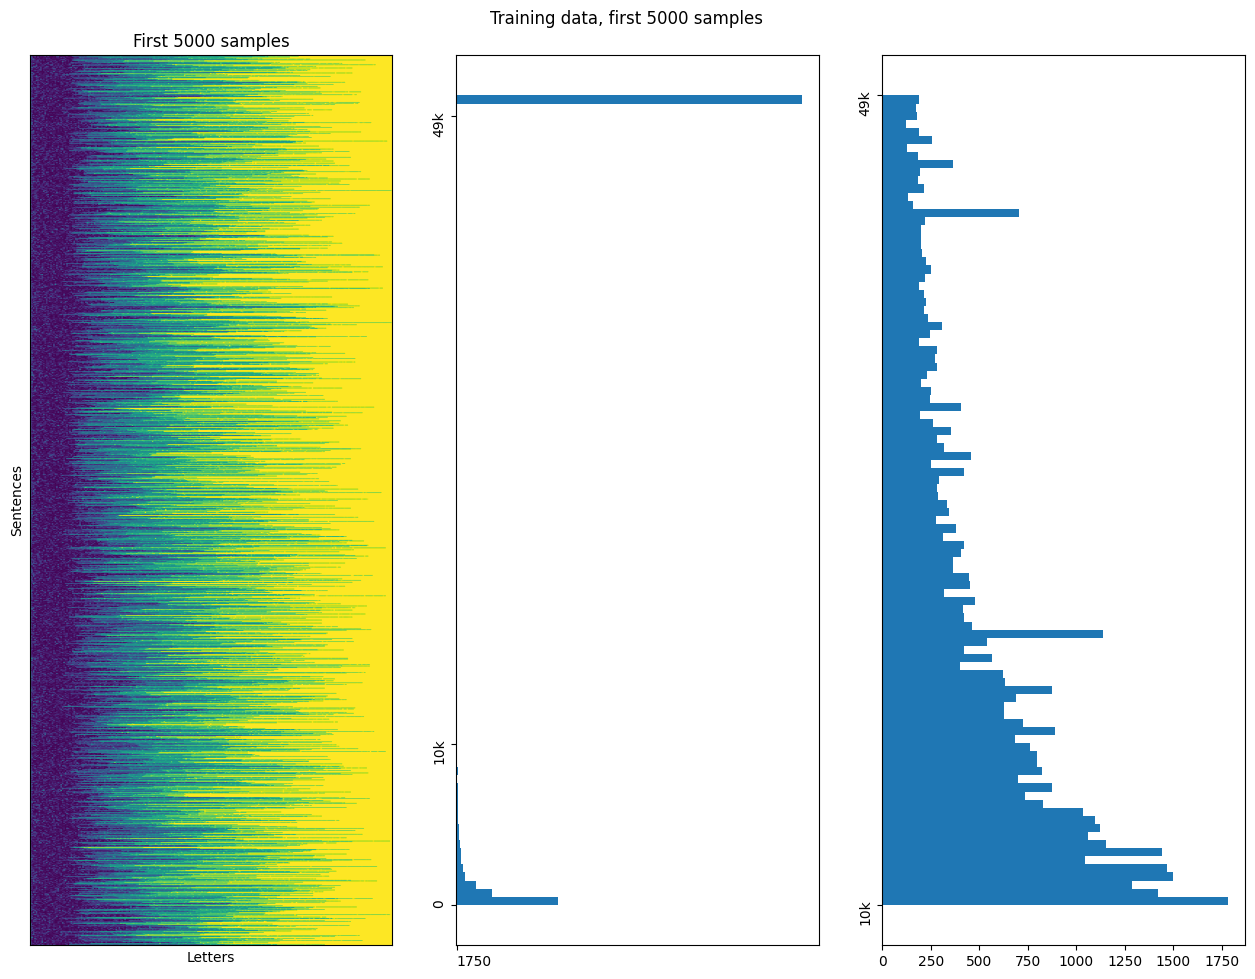

In [112]:
import matplotlib.pyplot as plt


train_text_slice = train_text[:5000]
flattened_slice = train_text_slice.flatten()
cut_slice = flattened_slice[flattened_slice < 49_000]
cut_slice = cut_slice[cut_slice > 10_000]

x_size = 13
y_size = 10
figsize = (x_size, y_size)
fig, ax = plt.subplots(1, 3, figsize=figsize)
fig.suptitle("Training data, first 5000 samples")
fig.tight_layout(pad=1.5)

_ = ax[0].imshow(train_text_slice, aspect="auto")
ax[0].set_title("First 5000 samples")
ax[0].set_xlabel("Letters")
ax[0].set_ylabel("Sentences")
ax[0].set_xticks([])
ax[0].set_yticks([])


# transposed histograms
_ = ax[1].hist(flattened_slice, bins=100, orientation="horizontal")
ax[1].set_yticks([0, 10_000, 49_000], rotation=90, labels=["0", "10k", "49k"])
ax[1].set_xticks([1750], rotation=0, labels=["1750"], ha="left")

_ = ax[2].hist(cut_slice, bins=100, orientation="horizontal")
ax[2].set_yticks([10_000, 49_000], rotation=90, labels=["10k", "49k"])



In [115]:
train_text.nbytes / 1024 / 1024 # in MB

1428.4324645996094

In [116]:
train_rating.nbytes / 1024 / 1024 # in MB

2.856865882873535